# CNN for HCM Classification

## Importing necessary dependencies

In [637]:
# Necessary Dependencies
import random
import ipynb.fs.full.HCM_Functions as HCM

from scipy import ndimage
from skimage import measure
from scipy import stats
import sklearn as skl
from sklearn import model_selection as m_s
from skimage.transform import rescale

import numpy as np
import pandas as pd
import math
import cv2

import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline 

import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)

import glob
import os
from os import listdir

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Pillow Version: 8.1.0


In [638]:
# Check to see if tensorflow detects GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Importing/Sorting Data

In [639]:
# Load in Image Table
Image_df = pd.read_excel('/home/beepul/HCM-Project/HCM_Methods_Data/OrganizedData/Final_4ChamberCineTable.xls')
Image_df.head()

,PatientNumber,RowSpacing,ColumnSpacing
0,100,1.25000,1.25000
1,101,1.25000,1.25000
2,103,1.25000,1.25000
3,106,1.40625,1.40625
4,107,1.25000,1.25000


In [640]:
# Load in EHR Table
# Load in Image Table
EHR_df = pd.read_excel('/home/beepul/HCM-Project/HCM_Methods_Data/OrganizedData/EHR_Data/HCM_EHR_with_VTVF_NSVT_Outcomes.xls')
EHR_df = EHR_df.drop('Unnamed: 0', axis = 1)

In [641]:
EHR_df[EHR_df['Adverse_Outcome'] == 1]

,MRN,MRN_MRI,MRI_ID,Last_Name_MRI,First_Name_Initial_MRI,Record_ID,LastName,FirstName,excl_myect,Myectomy,...,ICDimplantation,ICDshock,ICDshock_Number,AntiTachycardiaPacing,HF,Transplantation,Death,Stroke,MI,Adverse_Outcome
3,JH94072597,JH94072597,6,Adkins,T,10002,Adkins,Charles,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
5,JH74119810,JH74119810,8,Aherne,C,10495,Aherne,Michael,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
15,JH74750203,JH74750203,20,Anderson,E,10583,Anderson,Leif,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
16,JH64598450,JH64598450,21,Anarino,R,10215,Anarino,Lee,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
20,JH84340069,JH84340069,26,Armentrout,C,10007,Armentrout,Rebecca,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,JH25821941,JH25821941,804,Wishard,T,10771,Wishard,Faye,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
701,JH35704559,JH35704559,808,Wormley-Holston,M,10789,Wormley-Holston,Sarah,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
702,JH94621943,JH94621943,810,Wozniak,S,10881,Wozniak,Krystyna,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
703,JH14037970,JH14037970,811,Wright,D,10148,Wright,Joshua,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [642]:
# Obtain IDs from EHR Data
EHR_IDs = EHR_df['MRI_ID'].values

In [643]:
# Find EHR IDs in the Image df
Image_df = Image_df[Image_df['PatientNumber'].isin(EHR_IDs.astype(str))]
Image_df

,PatientNumber,RowSpacing,ColumnSpacing
0,100,1.250000,1.250000
1,101,1.250000,1.250000
2,103,1.250000,1.250000
3,106,1.406250,1.406250
4,107,1.250000,1.250000
...,...,...,...
634,794,1.250000,1.250000
635,805,1.339286,1.339286
636,811,1.406250,1.406250
637,812,1.339286,1.339286


In [644]:
# Find outcomes for patients in Image_df in EHR_data
Image_IDs = Image_df['PatientNumber'].values

In [645]:
# Add outcomes to Image_df
Outcomes = []
for ids in Image_IDs:
    Outcomes.append(EHR_df[EHR_df['MRI_ID'].astype(str) == ids].Adverse_Outcome.values[0])
Image_df['Outcomes'] = Outcomes

In [646]:
# Total Number of Positive Outcomes
np.sum(Image_df['Outcomes'])

114

In [647]:
# Creating X_res and Y_res columns
# Load images into directory
filepath = '/home/beepul/HCM-Project/Manual_4ChamberCine_wMasks'
TopDirectory = listdir(filepath)

In [648]:
# Load images of patients listed in Image_df 
masks = []
images = []
X_res = []
Y_res = [] 

for patients in Image_df.PatientNumber:
    path = filepath + '/' + patients
    image_path = path + '/' + listdir(path)[0]
    image_dir = listdir(image_path)
    img_mask = np.asarray(Image.open(image_path + '/' + 'Mask.png'))
    masks.append(img_mask)
    num_frames = len(image_dir) - 1
    X_res.append(img_mask.shape[1])
    Y_res.append(img_mask.shape[0])
    img_data = np.zeros((img_mask.shape[0],img_mask.shape[1],num_frames))
    for k in range(num_frames):
        framepath = image_path + '/' + str(k+1) + '.png'
        img_data[:,:,k] = np.asarray(Image.open(framepath))
    images.append(img_data)

In [649]:
# Calculate lengths and widths of image masks
X_res = []
Y_res = []
crop_masks = []
crop_images = []
for i, m in enumerate(masks):
    bbox = measure.regionprops(m.astype('uint8'))[0].bbox
    c_mask = m[bbox[0]:bbox[2],bbox[1]:bbox[3]]
    crop_images.append(images[i][bbox[0]:bbox[2],bbox[1]:bbox[3],:])
    crop_masks.append(c_mask)
    X_res.append(c_mask.shape[1])
    Y_res.append(c_mask.shape[0])

In [650]:
# Add X_res and Y_res columns to Image df
Image_df['X_res'] = X_res
Image_df['Y_res'] = Y_res

In [651]:
# Add X_length and Y_length columns to Image df
Image_df['X_Length'] = Image_df['ColumnSpacing']*Image_df['X_res']
Image_df['Y_Length'] = Image_df['RowSpacing']*Image_df['Y_res']

In [652]:
# Multiply cropped masks and cropped images together to isolate ROIs
roi_image = []
for j, c_m in enumerate(crop_masks):
    roi_image.append(crop_images[j]*c_m.reshape(c_m.shape[0],c_m.shape[1],1))

## Thresholding Function

In [653]:
# Thresholding Function
def Threshold(image,mask):
    pixels = []
    for i in range(image.shape[2]):
        im_slice = image[:,:,i]
        roi = im_slice*mask
        # Gaussian filtering
        blur = cv2.GaussianBlur(roi,(5,5),0)
        pixels = pixels + (np.ndarray.tolist(blur[mask == 1]))
    pixels = np.asarray(pixels)    
    p_98 = np.percentile(pixels,99)
    p_mod = pixels[pixels <= p_98]
    retval,t_img = cv2.threshold(np.asarray(p_mod).astype('uint16'),0,255,cv2.THRESH_OTSU)
    roi_volume = image*mask.reshape(mask.shape[0],mask.shape[1],1)
    threshold_image = (roi_volume > 0) & (roi_volume < retval)
    final_image = np.zeros((threshold_image.shape[0],threshold_image.shape[1],threshold_image.shape[2]))
    for k in range(threshold_image.shape[2]):
        final_image[:,:,k] = cv2.GaussianBlur(threshold_image[:,:,k].astype('float64'),(5,5),0)
    return final_image

## Data Augmentation

(array([  6.,  22.,  43.,  94., 118.,  98., 100.,  43.,  21.,   7.]),
 array([102.65625 , 111.265625, 119.875   , 128.484375, 137.09375 ,
        145.703125, 154.3125  , 162.921875, 171.53125 , 180.140625,
        188.75    ]),
 <BarContainer object of 10 artists>)

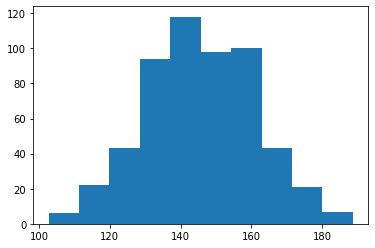

In [654]:
## Histogram of y_lengths
# This suggests that we may need to correct the padding. The largest length
# seems like an outlier and is most likely making us pad the other images too much
plt.hist(Image_df.Y_Length)

(array([ 11.,  51.,  92., 124., 123.,  76.,  44.,  18.,   9.,   4.]),
 array([112.5     , 123.046875, 133.59375 , 144.140625, 154.6875  ,
        165.234375, 175.78125 , 186.328125, 196.875   , 207.421875,
        217.96875 ]),
 <BarContainer object of 10 artists>)

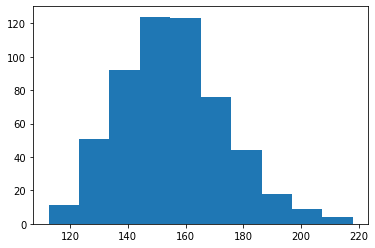

In [655]:
## Histogram of x_lengths
# This suggests that we may need to correct the padding. The largest length
# seems like an outlier and is most likely making us pad the other images too much
plt.hist(Image_df.X_Length)

In [656]:
# Fine largest image within the training set
max_x, max_y = Image_df.X_Length.max(), Image_df.Y_Length.max()
max_l = np.max([max_x,max_y])
Image_df[Image_df['X_Length'] == max_x]

,PatientNumber,RowSpacing,ColumnSpacing,Outcomes,X_res,Y_res,X_Length,Y_Length
334,556,1.40625,1.40625,1,155,122,217.96875,171.5625


In [657]:
max_l

217.96875

## Padding Function

In [751]:
# Function to properly pad images
# Input: Patient, current Y_Length, max y_length in Y direction, desired x and y resolution
# Output: Resized and padded image
def pad(image,d_x_res,d_y_res,C_x_Length,C_y_Length,max_length):
    num_frames = image.shape[2]
    p = d_x_res*(np.max([C_x_Length,C_y_Length]))/max_length
    c_x_res = image.shape[1]
    c_y_res = image.shape[0]
    scale = p/np.max([c_x_res,c_y_res])
    resized_image = np.zeros((d_x_res,d_y_res,num_frames))
    for j in range(num_frames):
        frame = image[:,:,j]
        resized_frame = rescale(frame,scale)
        pad_row = (d_y_res-resized_frame.shape[0])/2
        pad_col = (d_x_res-resized_frame.shape[1])/2
        padded_frame = np.pad(resized_frame,((math.floor(pad_row),math.ceil(pad_row)),
                                             (math.floor(pad_col),math.ceil(pad_col))),'constant')
        resized_image[:,:,j] = padded_frame
    return resized_image

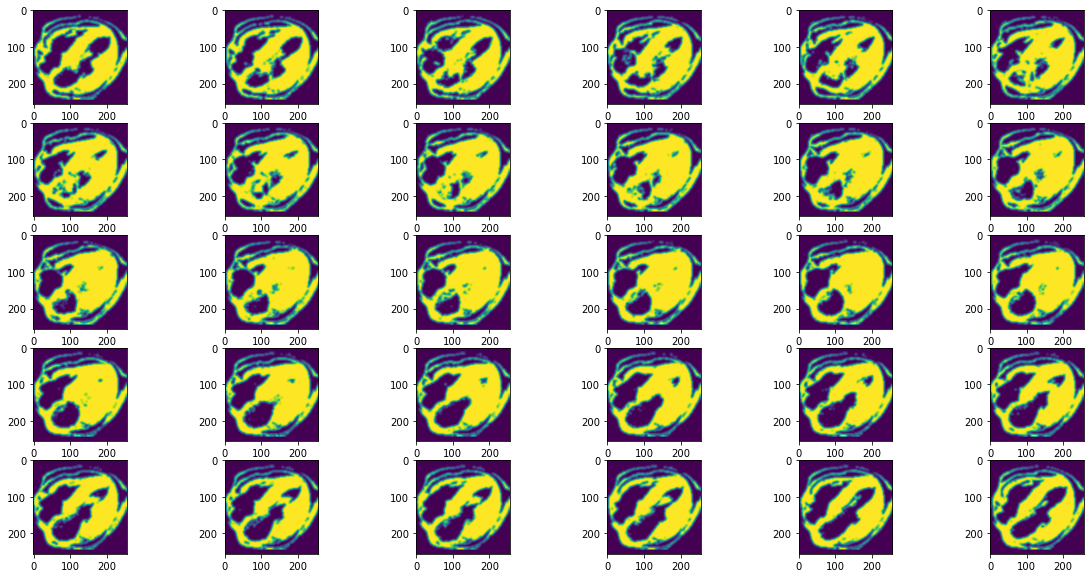

In [752]:
# Load random montage to ensure the padding works correctly
Image = Threshold(crop_images[334],crop_masks[334])
resized_image = pad(Image,256,256,Image_df.X_Length[334],Image_df.Y_Length[334],max_l)
volume = resized_image
plt.figure(figsize=(20,10))
columns = 6
for i in range(volume.shape[2]):
    image = volume[:,:,i]
    plt.subplot(5, columns, i + 1)
    plt.imshow(image)

In [660]:
Image_df

,PatientNumber,RowSpacing,ColumnSpacing,Outcomes,X_res,Y_res,X_Length,Y_Length
0,100,1.250000,1.250000,0,125,125,156.250000,156.250000
1,101,1.250000,1.250000,0,129,108,161.250000,135.000000
2,103,1.250000,1.250000,0,117,107,146.250000,133.750000
3,106,1.406250,1.406250,0,97,85,136.406250,119.531250
4,107,1.250000,1.250000,0,98,104,122.500000,130.000000
...,...,...,...,...,...,...,...,...
634,794,1.250000,1.250000,0,123,118,153.750000,147.500000
635,805,1.339286,1.339286,0,93,105,124.553573,140.625002
636,811,1.406250,1.406250,1,107,105,150.468750,147.656250
637,812,1.339286,1.339286,0,114,100,152.678573,133.928573


## Creating Training and Test Sets

In [661]:
IDs = Image_df.PatientNumber.values
Outcomes = Image_df.Outcomes.values

In [662]:
## Make validation set
## Stratified set
sss = m_s.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(IDs, Outcomes):
    print("TRAIN Size:", len(train_index), "Test Size:", len(test_index))

TRAIN Size: 441 Test Size: 111


In [731]:
# Make train df
train_ids = IDs[train_index]
training_df = Image_df[Image_df['PatientNumber'].isin(train_ids)]
training_df

,PatientNumber,RowSpacing,ColumnSpacing,Outcomes,X_res,Y_res,X_Length,Y_Length
0,100,1.250000,1.250000,0,125,125,156.250000,156.250000
1,101,1.250000,1.250000,0,129,108,161.250000,135.000000
2,103,1.250000,1.250000,0,117,107,146.250000,133.750000
3,106,1.406250,1.406250,0,97,85,136.406250,119.531250
4,107,1.250000,1.250000,0,98,104,122.500000,130.000000
...,...,...,...,...,...,...,...,...
633,783,1.250000,1.250000,1,125,117,156.250000,146.250000
634,794,1.250000,1.250000,0,123,118,153.750000,147.500000
635,805,1.339286,1.339286,0,93,105,124.553573,140.625002
636,811,1.406250,1.406250,1,107,105,150.468750,147.656250


In [746]:
# Isolate Training images and outcomes 
crop_images = np.asarray(crop_images, dtype = 'object')
crop_masks = np.asarray(crop_masks, dtype = 'object')
raw_train_images = crop_images[train_index]
train_masks = crop_masks[train_index]
training_labels = Outcomes[train_index]

In [770]:
# Train Images are currently CROPPED but NOT thresholded or padded or reduced to 30 frames if necessary
# Fill the arrays with the images properly padded and processed
# Each image in training_images is 256 x 256 x 30

training_images = np.empty((train_index.shape[0],256,256,30))

for i in range(raw_train_images.shape[0]):
    t_image = Threshold(raw_train_images[i],train_masks[i])
    padded_image = pad(t_image,256,256,training_df.X_Length.values[i],training_df.Y_Length.values[i],max_l)
    if padded_image.shape[2] == 50:
        training_images[i] =  HCM.frame_selection(padded_image)
    else:
        training_images[i] = padded_image

In [780]:
## Make validation set
## Stratified set
sss = m_s.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, val_index in sss.split(training_images, training_labels):
    print("TRAIN Size:", len(train_index), "Val Size:", len(val_index))

TRAIN Size: 352 Val Size: 89


In [781]:
# Making the training and validation sets
sub_train_images, sub_train_labels = training_images[train_index], training_labels[train_index]
val_images, val_labels = training_images[val_index], training_labels[val_index]

In [782]:
# Load the images and labels into proper tensor format
train_loader = tf.data.Dataset.from_tensor_slices((sub_train_images, sub_train_labels))
validation_loader = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

In [783]:
# Function to add 4th dimension to image
def add_dim(image, label):
    """Process image by adding a channel."""
    processed_image = tf.expand_dims(image, axis=3)
    return processed_image, label

In [784]:
batch_size = 5
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(sub_train_images))
    .map(add_dim)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(val_images))
    .map(add_dim)
    .batch(batch_size)
    .prefetch(2)
)

## CNN

In [785]:
# Currently Assuming that the input images are 150x150 with 30 frames
# Channel = 1 because they are grayscale
# This architecure is DEFINITELY subject to change

# Input Data
input_data = layers.Input([256,256,30,1])
initializer1 = tf.keras.initializers.he_normal()
initializer2 = tf.keras.initializers.GlorotNormal()

# Conv 1.1
encoder = Conv3D(4,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(input_data)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(4,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (2,2,2), strides=(2,2,2))(encoder)

# Conv 2.1
encoder = Conv3D(8,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(8,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (2,2,3), strides=(2,2,3))(encoder)

# Conv 3.1
encoder = Conv3D(16,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(16,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (4,4,5), strides=(4,4,5), padding = "same")(encoder)

# Size of data after convolutional layers
volumesize = tf.keras.backend.int_shape(encoder)

# Fully Connected
# 1st layer
encoder = Flatten()(encoder)
dense1_size = tf.keras.backend.int_shape(encoder)

# 2nd layer
encoder = layers.Dense(100,activation = 'relu', kernel_initializer = initializer1)(encoder)

# Classifying layer
encoder_cnn = layers.Dense(1,activation = 'sigmoid', kernel_initializer = initializer2)(encoder)

In [786]:
# Summary of the encoder 
model = tf.keras.Model(input_data, encoder_cnn, name="HCM_CNN")
model.summary()

Model: "HCM_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 30, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 256, 256, 30, 4)   112       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 30, 4)   16        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 256, 256, 30, 4)   436       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 30, 4)   16        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 128, 128, 15, 4)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 128, 128, 15, 8)   872 

In [787]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

In [788]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg = len(training_labels[training_labels == 0])
pos = len(training_labels[training_labels == 1])
total = len(training_labels)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.63
Weight for class 1: 2.42


In [789]:
# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 10
model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
    class_weight = class_weight
)

Epoch 1/10
71/71 - 27s - loss: 1.2050 - acc: 0.4545 - val_loss: 0.6545 - val_acc: 0.6404
Epoch 2/10
71/71 - 21s - loss: 0.8199 - acc: 0.6761 - val_loss: 0.5585 - val_acc: 0.7640
Epoch 3/10
71/71 - 22s - loss: 0.5615 - acc: 0.7386 - val_loss: 0.5224 - val_acc: 0.7640
Epoch 4/10
71/71 - 24s - loss: 0.6269 - acc: 0.7017 - val_loss: 0.5183 - val_acc: 0.7753
Epoch 5/10
71/71 - 21s - loss: 0.3908 - acc: 0.8097 - val_loss: 0.5327 - val_acc: 0.7753
Epoch 6/10
71/71 - 21s - loss: 0.3021 - acc: 0.8636 - val_loss: 0.6890 - val_acc: 0.8090
Epoch 7/10
71/71 - 21s - loss: 0.2533 - acc: 0.8949 - val_loss: 0.6093 - val_acc: 0.7978
Epoch 8/10
71/71 - 21s - loss: 0.1265 - acc: 0.9574 - val_loss: 0.6644 - val_acc: 0.6966
Epoch 9/10
71/71 - 21s - loss: 0.0974 - acc: 0.9886 - val_loss: 0.7881 - val_acc: 0.6404
Epoch 10/10
71/71 - 21s - loss: 0.0629 - acc: 0.9943 - val_loss: 0.7076 - val_acc: 0.7978


In [824]:
prediction = model.predict(val_images, batch_size = 1)

In [846]:
p5 = []
for val in (prediction):
    p5.append(val[0])

In [810]:
prediction = model.predict(np.expand_dims(val_images[28], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]
scores

[0.053692400455474854, 0.9463076]

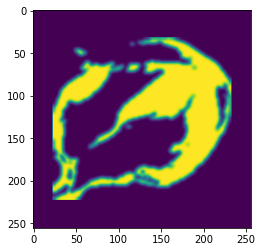

In [813]:
plt.imshow(val_images[28][:,:,20])

## Model Visualization

In [850]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input_1',
 'conv3d',
 'batch_normalization',
 'conv3d_1',
 'batch_normalization_1',
 'max_pooling3d',
 'conv3d_2',
 'batch_normalization_2',
 'conv3d_3',
 'batch_normalization_3',
 'max_pooling3d_1',
 'conv3d_4',
 'batch_normalization_4',
 'conv3d_5',
 'batch_normalization_5',
 'max_pooling3d_2',
 'flatten',
 'dense',
 'dense_1']

In [851]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<tf.Tensor 'input_1:0' shape=(None, 256, 256, 30, 1) dtype=float32>,
 <tf.Tensor 'conv3d/Identity:0' shape=(None, 256, 256, 30, 4) dtype=float32>,
 <tf.Tensor 'batch_normalization/Identity:0' shape=(None, 256, 256, 30, 4) dtype=float32>,
 <tf.Tensor 'conv3d_1/Identity:0' shape=(None, 256, 256, 30, 4) dtype=float32>,
 <tf.Tensor 'batch_normalization_1/Identity:0' shape=(None, 256, 256, 30, 4) dtype=float32>,
 <tf.Tensor 'max_pooling3d/Identity:0' shape=(None, 128, 128, 15, 4) dtype=float32>,
 <tf.Tensor 'conv3d_2/Identity:0' shape=(None, 128, 128, 15, 8) dtype=float32>,
 <tf.Tensor 'batch_normalization_2/Identity:0' shape=(None, 128, 128, 15, 8) dtype=float32>,
 <tf.Tensor 'conv3d_3/Identity:0' shape=(None, 128, 128, 15, 8) dtype=float32>,
 <tf.Tensor 'batch_normalization_3/Identity:0' shape=(None, 128, 128, 15, 8) dtype=float32>,
 <tf.Tensor 'max_pooling3d_1/Identity:0' shape=(None, 64, 64, 5, 8) dtype=float32>,
 <tf.Tensor 'conv3d_4/Identity:0' shape=(None, 64, 64, 5, 16) dtype=float

In [852]:
#recreate a network and predict the outputs of each layer with an image
feature_map_model = tf.keras.models.Model(inputs=input_data, outputs=layer_outputs)
image1 = val_images[1,:,:,:]
image2 = tf.expand_dims(image1, axis=3)
image2 = tf.expand_dims(image1, axis=0)
print(val_images.shape, image1.shape, image2.shape)
feature_maps = feature_map_model.predict(image2)
len(feature_maps)

(89, 256, 256, 30) (256, 256, 30) (1, 256, 256, 30)


19

In [853]:
for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the input_1 is =======>> (1, 256, 256, 30, 1)
The shape of the conv3d is =======>> (1, 256, 256, 30, 4)
The shape of the batch_normalization is =======>> (1, 256, 256, 30, 4)
The shape of the conv3d_1 is =======>> (1, 256, 256, 30, 4)
The shape of the batch_normalization_1 is =======>> (1, 256, 256, 30, 4)
The shape of the max_pooling3d is =======>> (1, 128, 128, 15, 4)
The shape of the conv3d_2 is =======>> (1, 128, 128, 15, 8)
The shape of the batch_normalization_2 is =======>> (1, 128, 128, 15, 8)
The shape of the conv3d_3 is =======>> (1, 128, 128, 15, 8)
The shape of the batch_normalization_3 is =======>> (1, 128, 128, 15, 8)
The shape of the max_pooling3d_1 is =======>> (1, 64, 64, 5, 8)
The shape of the conv3d_4 is =======>> (1, 64, 64, 5, 16)
The shape of the batch_normalization_4 is =======>> (1, 64, 64, 5, 16)
The shape of the conv3d_5 is =======>> (1, 64, 64, 5, 16)
The shape of the batch_normalization_5 is =======>> (1, 64, 64, 5, 16)
The shape of the max_pooli

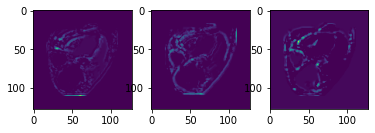

In [854]:
conv_l = [1,7] #first 2 convolutional layers
slice = 4
channel = 3
feature_image1 = feature_image = feature_maps[conv_l[0]]
feature_image2 = feature_image = feature_maps[conv_l[1]]

columns = channel
for i in range(channel):
    plt.subplot(1, columns, i + 1)
    plt.imshow(feature_image2[0,:,:,slice,i + 1])